# Code for TASK 2.1.a

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Input, BatchNormalization, Activation
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
from tensorflow.python.framework.ops import SymbolicTensor
import matplotlib.pyplot as plt
import os

from get_dataset import download_data

2025-11-07 22:28:53.636930: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-07 22:28:53.665529: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-07 22:28:57.347007: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [ ]:
NUM_CLASSES = 24
BATCH_SIZE = 128
EPOCHS = 1000 # we use early stopping, so not all epochs will be used

def print_metrics(pred_hours, true_hours, model_name, num_classes=NUM_CLASSES):
    """Print comprehensive evaluation metrics."""
    diff_min = common_sense_categories_loss(true_hours,pred_hours) #returns common sense loss in minutes from one hot encoded labels
    
    mean_err = np.mean(diff_min)
    median_err = np.median(diff_min)
    std_err = np.std(diff_min)
    max_err = np.max(diff_min)
    
    within_0 = np.mean(diff_min <= 0) * 100
    within_1 = np.mean(diff_min <= 1) * 100
    within_5 = np.mean(diff_min <= 5) * 100
    within_10 = np.mean(diff_min <= 10) * 100
    within_15 = np.mean(diff_min <= 15) * 100
    within_30 = np.mean(diff_min <= 30) * 100

    print(f"\n{'=' * 80}")
    print(f"{model_name} - TEST SET RESULTS")
    print(f"{'=' * 80}")
    print(f"Mean Absolute Common Sense Loss:    {mean_err:.2f} minutes")
    print(f"Median Absolute Common Sense Loss:  {median_err:.2f} minutes")
    print(f"Std Deviation:                      {std_err:.2f} minutes")
    print(f"Max Common Sense Loss:              {max_err:.2f} minutes")
    print(f"\nAccuracy within thresholds:")
    print(f"  Within 30 minutes:                {within_30:.1f}%")
    print(f"  Within 15 minutes:                {within_15:.1f}%")
    print(f"  Within 10 minutes:                {within_10:.1f}%")
    print(f"  Within 5 minutes:                 {within_5:.1f}%")
    print(f"  Within 1 minute:                  {within_1:.1f}%")
    print(f"  Accuracy:                         {within_0:.1f}%")
    
    return {
        'mean': mean_err,
        'median': median_err,
        'std': std_err,
        'max': max_err,
        'accuracy': within_0,
        'within_1': within_1,
        'within_5': within_5,
        'within_10': within_10,
        'within_15': within_15,
        'within_30': within_30,
        'predictions': pred_hours,
        'errors': diff_min
    }

def to_categorical(y, num_classes):
    """
    --------------------------------------------
    Convert time to categorical labels.
    --------------------------------------------
    :param y: numpy array of shape (num_samples, 2) where the first column is hour (0-11)
              and the second column is minute (0-59)
    :param num_classes: total number of classes
    :return: numpy array with one-hot encoded labels that represent the class that the elements of y belong to
    """
    # check if it is already one-hot encoded
    if y.shape[1] == num_classes:
        return y

    class_ph = num_classes//12                    # amount of classes per hour
    class_pm = 60//class_ph                       # amount of classes per minute
    class_ = y[:, 0]*class_ph + y[:, 1]//class_pm # if num_class is 24, then per 30 min is the next class.

    return keras.utils.to_categorical(class_, num_classes)

@tf.keras.utils.register_keras_serializable()
def common_sense_categories_loss(y_true: SymbolicTensor, y_pred: SymbolicTensor, num_classes = NUM_CLASSES) -> SymbolicTensor:
    """
    --------------------------------------------
    Get common sense loss for categories
    --------------------------------------------
    :param y_true: tensor filled with tensors with true labels
    :param y_pred: tensor filled with tensors with predicted labels
    :return: accuracy loss tensor

    Common sense loss formula: 
    (highest possible common sence loss) = cls = min(|true_class-pred_class|, ||true_class-pred_class| - number_of_classes|)
    csl*category_size_in_minutes = common sense loss in minutes
    """
    # read what the class is
    y_true = tf.argmax(y_true, axis=-1) # when printed gives: tf.Tensor(0, shape=(), dtype=int64), here it gives 0 because it is class 0
    y_pred = tf.argmax(y_pred, axis=-1)

    #calc common sense loss (cls)
    diff = tf.abs(y_true - y_pred)                        # difference (not common sence yet)
    csl = tf.minimum(diff, tf.abs(diff - num_classes))    # highest possible common sence loss (=common sence difference)
    minutes_per_class = 60//(num_classes//12)             # how many minutes per class
    return csl * minutes_per_class                        # return common sense loss in minutes


@tf.keras.utils.register_keras_serializable()
def common_sense_mse(y_true,y_pred, num_classes=NUM_CLASSES):
    """
    --------------------------------------------
    Get mean squared error with common sense
    --------------------------------------------
    :param y_true: tensor filled with tensors with true labels
    :param y_pred: tensor filled with tensors with predicted labels
    :return: mean squared error (MSE) with common sense incorporated (MSE, but we make classes that are further away have more loss)

    Make a distribution that is bigger in value when farther away from the correct class. 
    That distribution is then used as weights to alter the mean squared error (MSE).
    What is returned is: MSE * distribution
    """
    # precausion, make them have the same dtype
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    # get squared difference
    diff = tf.square(y_true - y_pred)  # shape (batch, num_classes)

    # get the class
    class_by_mult = tf.range(num_classes, dtype=tf.float32)
    true_class = tf.reduce_sum(y_true * class_by_mult, axis=-1) 
    true_class = tf.cast(true_class, tf.int32)  # must be int for tf.roll
    
    # get distribution based on absolute distance for when index = 0
    dist = [1]
    max_amount = np.ceil(num_classes / 2)
    for i in range(2,int(max_amount)+1):
        dist.append(i)
    for i in range(int(max_amount)+1,1,-1):
        dist.append(i)
    dist = tf.constant(dist, dtype=tf.float32)

    # rotate distribution so that value 1 aligns with the true class
    # Ex: when index=0 is the correct class, then the distribution 
    # for 4 classes would look like this: [1,2,3,2]
    # , when index = 1 it would look like this: [2,1,2,3]
    def rotate_dist(idx):
        idx = tf.reshape(idx, ())  # make is a scalar
        row = tf.roll(dist, shift=idx, axis=0)
        return row

    dist_matrix = tf.map_fn(rotate_dist, true_class, fn_output_signature=tf.float32) # loop over true_class rows

    # multiply squared difference by distance weights
    diff_with_common_sense = diff * dist_matrix

    # average over classes to get the MSE with common_sense incorporated
    loss = tf.reduce_mean(diff_with_common_sense, axis=-1)
    return loss

@tf.keras.utils.register_keras_serializable()
def common_sense_mse_720(y_true,y_pred):
    return common_sense_mse(y_true,y_pred, num_classes=720)

@tf.keras.utils.register_keras_serializable()
def common_sense_mse_0(y_true,y_pred, num_classes=NUM_CLASSES):
    """
    --------------------------------------------
    Get mean squared error with common sense
    --------------------------------------------
    :param y_true: tensor filled with tensors with true labels
    :param y_pred: tensor filled with tensors with predicted labels
    :return: mean squared error (MSE) with common sense incorporated (MSE, but we make classes that are further away have more loss)

    Make a distribution that is bigger in value when farther away from the correct class. 
    That distribution is then used as weights to alter the mean squared error (MSE).
    What is returned is: MSE * distribution
    """
    # precausion, make them have the same dtype
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    # get squared difference
    diff = tf.abs(y_true - y_pred)  # shape (batch, num_classes)

    # get the class
    class_by_mult = tf.range(num_classes, dtype=tf.float32)
    true_class = tf.reduce_sum(y_true * class_by_mult, axis=-1) 
    true_class = tf.cast(true_class, tf.int32)  # must be int for tf.roll
    
    # get distribution based on absolute distance for when index = 0
    dist = [0]
    max_amount = np.ceil(num_classes / 2)
    for i in range(1,int(max_amount)):
        dist.append(i)
    for i in range(int(max_amount),0,-1):
        dist.append(i)
    dist = tf.constant(dist, dtype=tf.float32)

    # rotate distribution so that value 0 aligns with the true class
    # Ex: when index=0 is the correct class, then the distribution 
    # for 4 classes would look like this: [0,1,2,1]
    # , when index = 1 it would look like this: [1,0,1,2]
    def rotate_dist(idx):
        idx = tf.reshape(idx, ())  # make it a scalar
        row = tf.roll(dist, shift=idx, axis=0)
        return row

    dist_matrix = tf.map_fn(rotate_dist, true_class, fn_output_signature=tf.float32) # loop over true_class rows

    # multiply squared difference by distance weights
    diff_with_common_sense = diff * dist_matrix

    # average over classes to get the MSE with common_sense incorporated
    loss = tf.reduce_mean(tf.square(diff_with_common_sense), axis=-1)
    return loss

def load_data(seed: int,easy=True) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, tuple[int, int, int]]:
    url = r"https://surfdrive.surf.nl/public.php/dav/files/Nznt5c48Mzlb2HY/A1_data_75.zip"
    download_data(url)

    url = r"https://surfdrive.surf.nl/public.php/dav/files/Nznt5c48Mzlb2HY/A1_data_150.zip"
    download_data(url)
    # choose dataset
    if easy:
        X = np.load("data/A1_data_75/images.npy")
        y = np.load("data/A1_data_75/labels.npy")
    else:
        X = np.load("data/A1_data_150/images.npy")
        y = np.load("data/A1_data_150/labels.npy")

    X = X / 255
    # Split into train/val/test (80/10/10)
    X_train_full, X_test, y_train_full, y_test = train_test_split(
        X, y, test_size=0.10, random_state=seed, shuffle=True
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_full, y_train_full, test_size=0.1111, random_state=seed, shuffle=True
    )

    # Add channel dimension for CNN
    img_rows, img_cols = X_train.shape[1], X_train.shape[2]
    input_shape = (img_rows, img_cols, 1)

    if K.image_data_format() == 'channels_first':
        X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
        X_val = X_val.reshape(X_val.shape[0], 1, img_rows, img_cols)
        X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
        input_shape = (1, img_rows, img_cols)
    else:
        X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
        X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols, 1)
        X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
        input_shape = (img_rows, img_cols, 1)

    return X_train, y_train, X_val, y_val, X_test, y_test, input_shape


def build_cnn_catagorical(input_shape, num_classes):
    """CNN for predicting categorical values."""
    inputs = Input(shape=input_shape)
    
    # First conv block
    x = Conv2D(32, (3, 3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.2)(x)

    # Second conv block
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.2)(x)

    # Third conv block
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)

    # Dense layers
    x = Flatten()(x)
    x = Dense(256)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.4)(x)

    x = Dense(128)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.3)(x)

    # Output layer: num_classes amount of nodes
    outputs = Dense(num_classes, activation='softmax')(x)

    return keras.Model(inputs, outputs, name="cnn_classification")


def preprocess_cat(easy=True, num_classes=NUM_CLASSES):
    # preprocessing categorical data
    X_train, y_train, X_val, y_val, X_test, y_test, input_shape = load_data(seed=42, easy=easy)

    # Convert labels to one-hot encoding given the number of classes
    y_train = to_categorical(y_train, num_classes)
    y_val = to_categorical(y_val, num_classes)
    y_test = to_categorical(y_test, num_classes)

    return X_train, y_train, X_val, y_val, X_test, y_test, input_shape


def experiment_cat(loss_function, model_name: str, easy=True, num_classes=NUM_CLASSES):
    """-------------------
    Run experiment for categorical models, saves models that can be used to plot the graphs.
    -------------------
    :param loss_function: loss function to use
    :param model_name: name of the model (for saving purposes)
    :param easy: whether to use the easy dataset or hard dataset
    """
    # set seeds
    seed=42
    np.random.seed(seed)
    tf.random.set_seed(seed)
    keras.utils.set_random_seed(seed)

    # load preprocessed data
    X_train, y_train, X_val, y_val, X_test, y_test, input_shape = preprocess_cat(easy,num_classes)

    # init model
    model = build_cnn_catagorical(input_shape, num_classes)
    

    # use a chosen loss function and common sense loss as metric and init optimizer and learning rate
    model.compile(loss=loss_function,
                optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                metrics=[common_sense_categories_loss])
    
    # show model information
    model.summary()

    # make callback that lowers the learning rate when a plateau is reached and has early stopping
    callbacks = [
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss', patience=5, factor=0.5, verbose=1, min_lr=1e-7
        ),
        keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=15, verbose=1, restore_best_weights=True
        )
    ]
    # train model
    model.fit(X_train, y_train,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            verbose=1,
            callbacks=callbacks,
            validation_data=(X_val, y_val))
    
    # save model
    model.save(f'saved_models/loss_{model_name}.keras')


# RUN experiment

In [ ]:
os.makedirs('saved_models', exist_ok=True)
    
# run experiments for different loss functions and the hard dataset (150 dataset)
experiment_cat(loss_function=common_sense_mse, model_name="common_sense_mse", easy=False)
experiment_cat(loss_function=common_sense_mse_0, model_name="common_sense_mse_0", easy=False)
experiment_cat(loss_function=keras.losses.MSE, model_name="mse", easy=False)
experiment_cat(loss_function=keras.losses.categorical_crossentropy, model_name="crossentropy", easy=False)

# run experiments for different loss functions and the hard dataset
experiment_cat(loss_function=common_sense_mse_720, model_name="common_sense_mse_hard", easy=False, num_classes=720)
print("Done!")

# Save plots in images/categorical and print metrics

give what models to plot

In [4]:
def get_models():
    model_list= ["loss_common_sense_mse","loss_common_sense_mse_0","loss_mse","loss_crossentropy","loss_common_sense_mse_hard"]
    return model_list

plot models and metrics

file does not exist
file does not exist


I0000 00:00:1762551034.390803  447705 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6127 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060, pci bus id: 0000:01:00.0, compute capability: 8.9
2025-11-07 22:30:35.317824: I external/local_xla/xla/service/service.cc:163] XLA service 0x7ade6800ba90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-07 22:30:35.317842: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9
2025-11-07 22:30:35.325420: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-07 22:30:35.369528: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91400
2025-11-07 22:30:35.379347: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs wer

21/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

I0000 00:00:1762551037.157904  447960 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step

loss_common_sense_mse - TEST SET RESULTS
Mean Absolute Common Sense Loss:    1.48 minutes
Median Absolute Common Sense Loss:  0.00 minutes
Std Deviation:                      8.79 minutes
Max Common Sense Loss:              210.00 minutes

Accuracy within thresholds:
  Within 30 minutes:                99.2%
  Within 15 minutes:                96.2%
  Within 10 minutes:                96.2%
  Within 5 minutes:                 96.2%
  Within 1 minute:                  96.2%
  Accuracy:                         96.2%


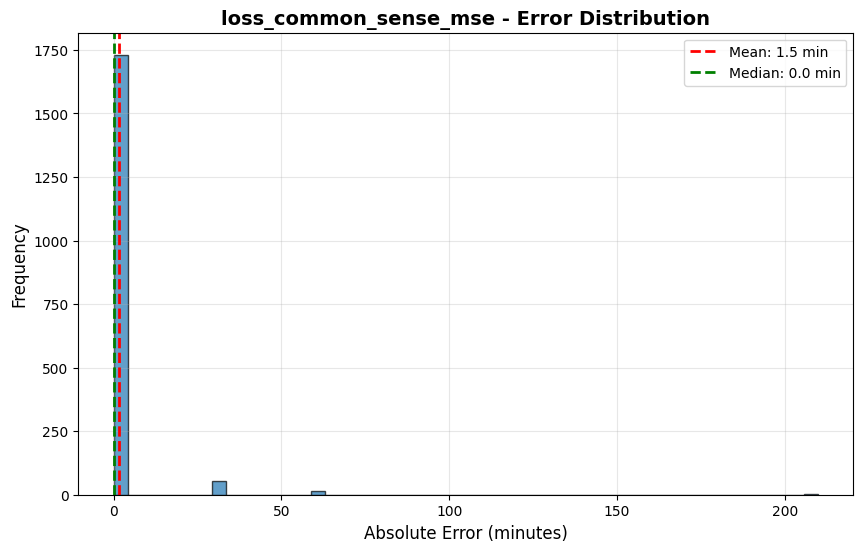

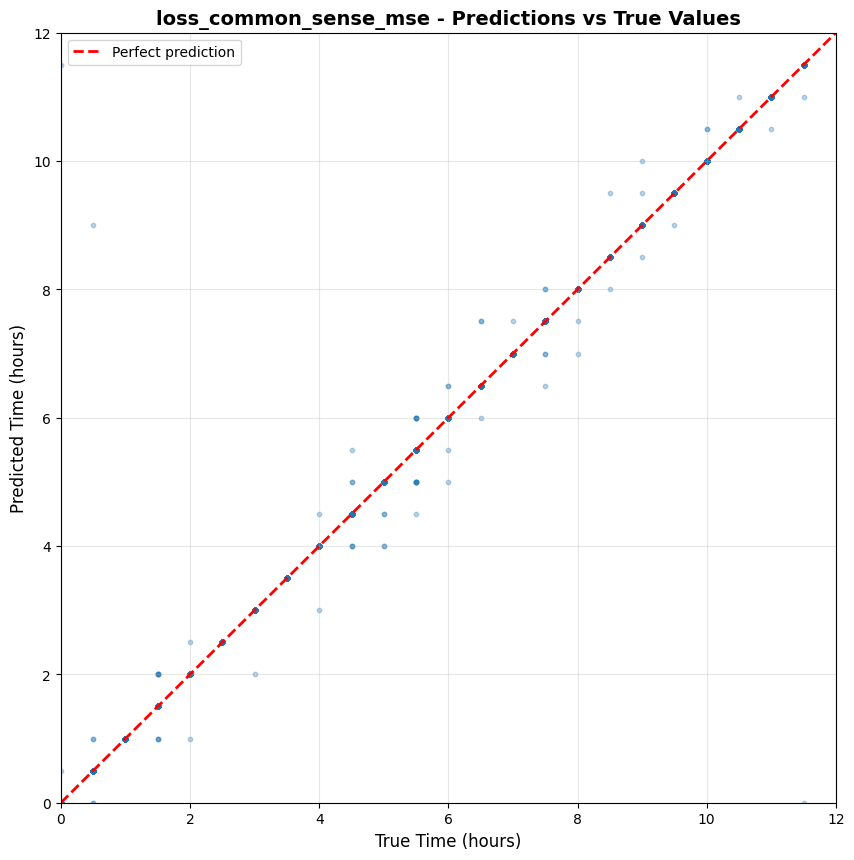

file does not exist
file does not exist
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step

loss_common_sense_mse_0 - TEST SET RESULTS
Mean Absolute Common Sense Loss:    4.25 minutes
Median Absolute Common Sense Loss:  0.00 minutes
Std Deviation:                      10.97 minutes
Max Common Sense Loss:              60.00 minutes

Accuracy within thresholds:
  Within 30 minutes:                99.4%
  Within 15 minutes:                86.4%
  Within 10 minutes:                86.4%
  Within 5 minutes:                 86.4%
  Within 1 minute:                  86.4%
  Accuracy:                         86.4%


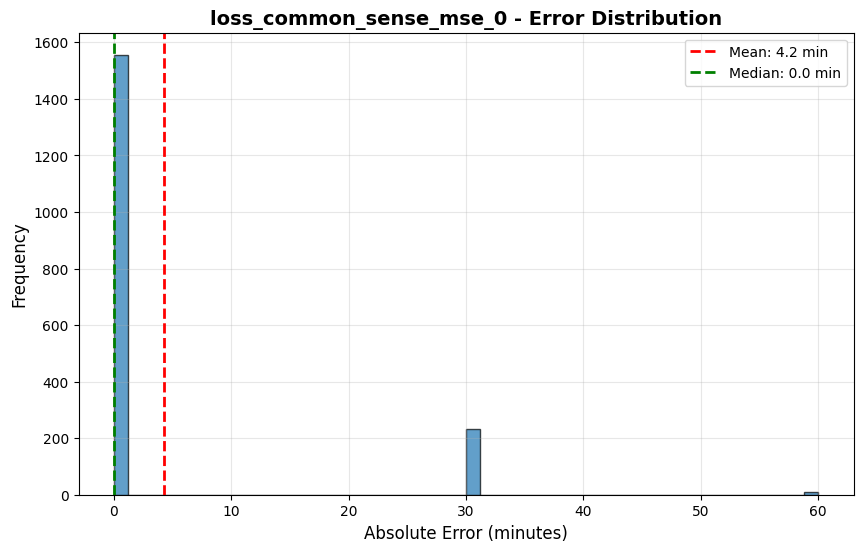

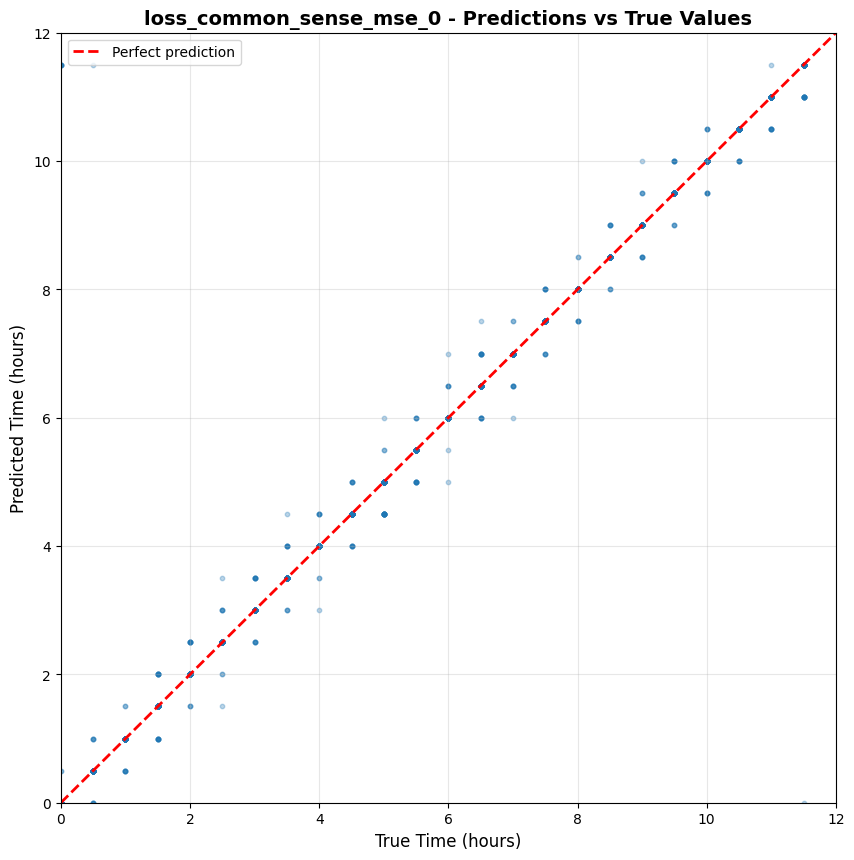

file does not exist
file does not exist
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step

loss_mse - TEST SET RESULTS
Mean Absolute Common Sense Loss:    2.82 minutes
Median Absolute Common Sense Loss:  0.00 minutes
Std Deviation:                      17.99 minutes
Max Common Sense Loss:              330.00 minutes

Accuracy within thresholds:
  Within 30 minutes:                98.0%
  Within 15 minutes:                94.8%
  Within 10 minutes:                94.8%
  Within 5 minutes:                 94.8%
  Within 1 minute:                  94.8%
  Accuracy:                         94.8%


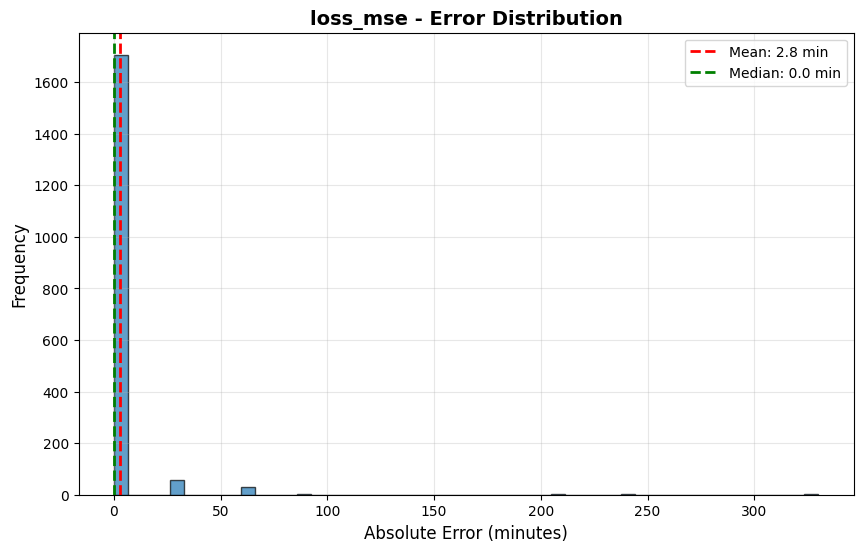

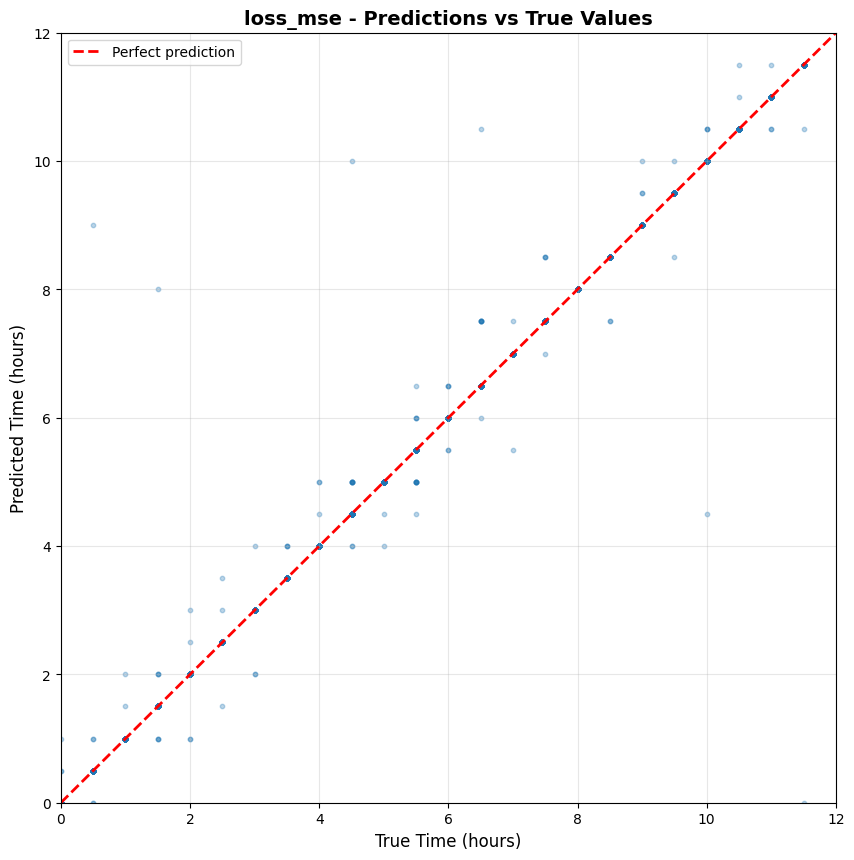

file does not exist
file does not exist
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step

loss_crossentropy - TEST SET RESULTS
Mean Absolute Common Sense Loss:    2.73 minutes
Median Absolute Common Sense Loss:  0.00 minutes
Std Deviation:                      13.98 minutes
Max Common Sense Loss:              330.00 minutes

Accuracy within thresholds:
  Within 30 minutes:                97.1%
  Within 15 minutes:                94.6%
  Within 10 minutes:                94.6%
  Within 5 minutes:                 94.6%
  Within 1 minute:                  94.6%
  Accuracy:                         94.6%


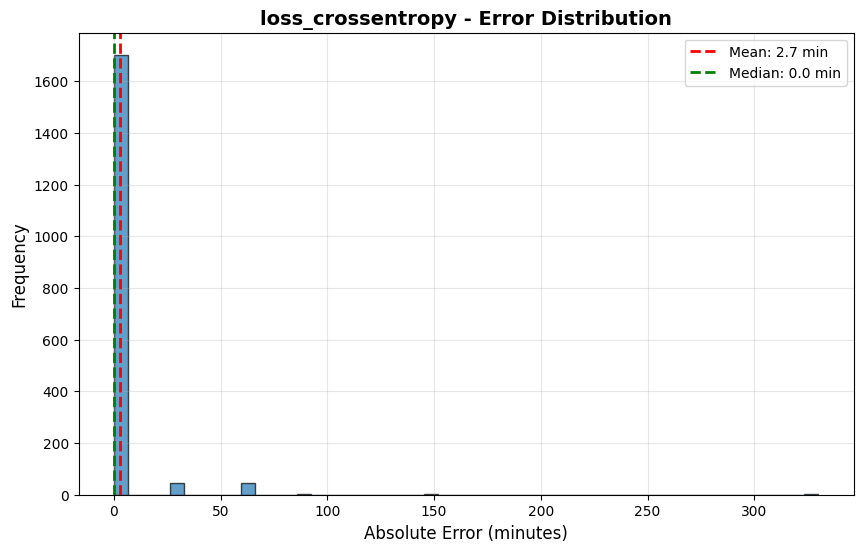

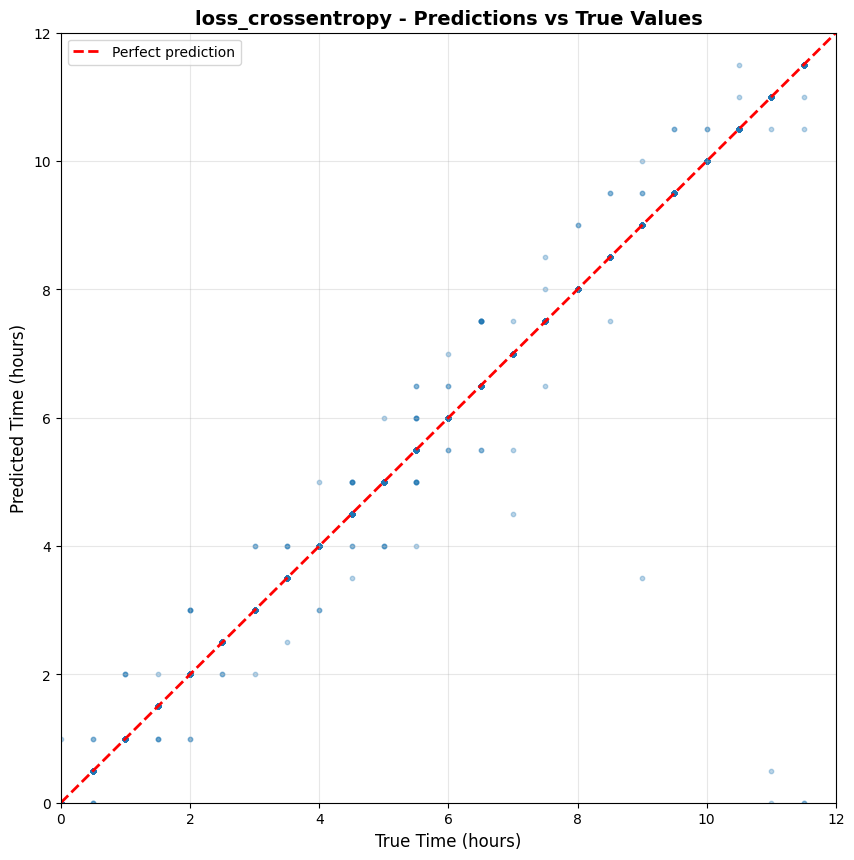

file does not exist
file does not exist
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step

loss_common_sense_mse_hard - TEST SET RESULTS
Mean Absolute Common Sense Loss:    857.10 minutes
Median Absolute Common Sense Loss:  210.00 minutes
Std Deviation:                      3319.79 minutes
Max Common Sense Loss:              20760.00 minutes

Accuracy within thresholds:
  Within 30 minutes:                11.3%
  Within 15 minutes:                3.8%
  Within 10 minutes:                3.8%
  Within 5 minutes:                 3.8%
  Within 1 minute:                  3.8%
  Accuracy:                         3.8%


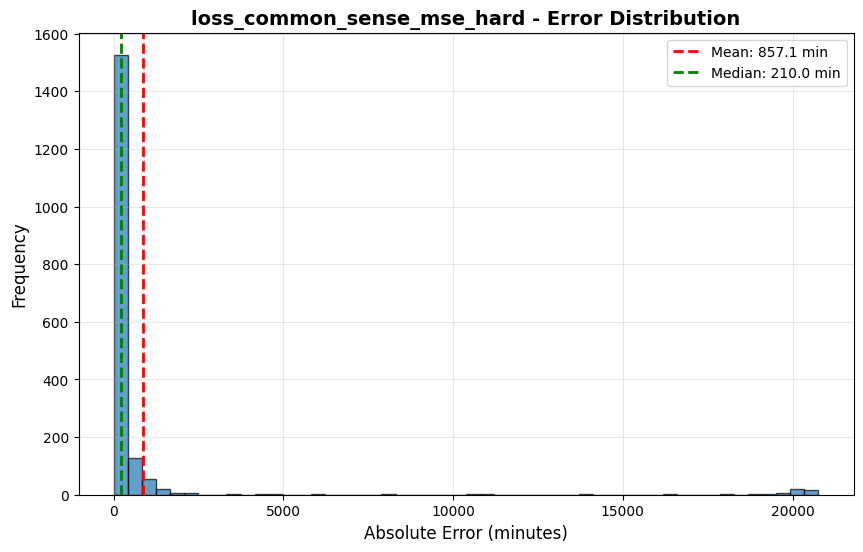

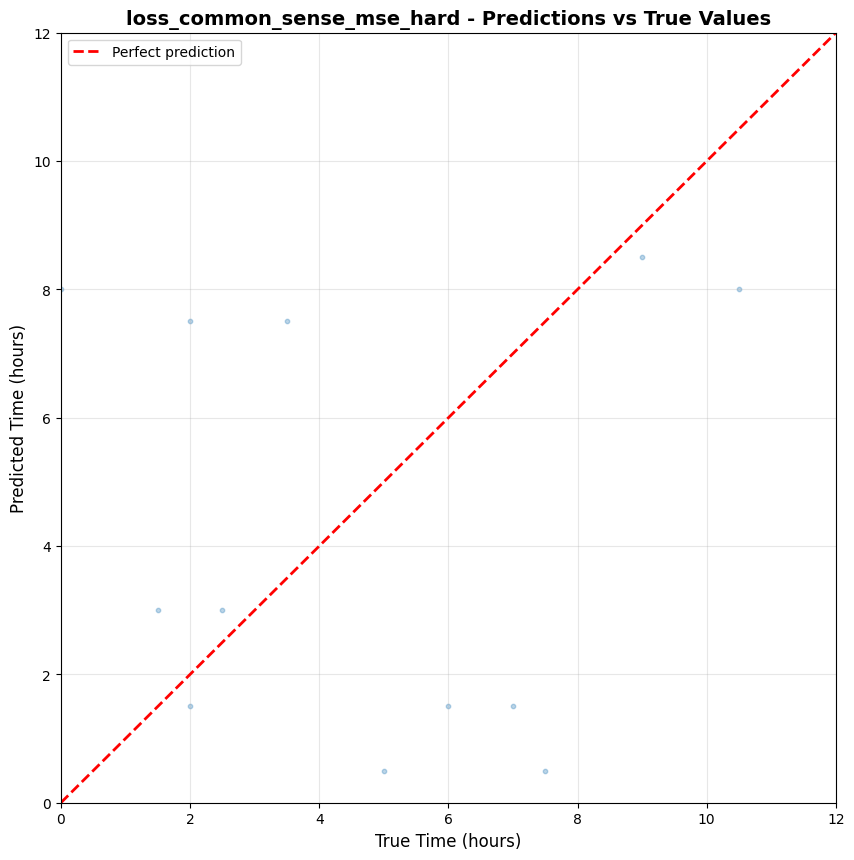

In [7]:
# RUN THIS TO CREATE PLOTS FOR CATEGORICAL MODELS AND PRINT METRICS

def plot_error_histogram(errors, model_name, save_path=None):
    """Plot histogram of prediction errors."""
    plt.figure(figsize=(10, 6))
    plt.hist(errors, bins=50, edgecolor='black', alpha=0.7)
    plt.xlabel('Absolute Error (minutes)', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.title(f'{model_name} - Error Distribution', fontsize=14, fontweight='bold')
    plt.axvline(np.mean(errors), color='r', linestyle='--', linewidth=2, label=f'Mean: {np.mean(errors):.1f} min')
    plt.axvline(np.median(errors), color='g', linestyle='--', linewidth=2, label=f'Median: {np.median(errors):.1f} min')
    plt.legend()
    plt.grid(True, alpha=0.3)
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


def plot_predictions_vs_true(pred_classes, true_classes, model_name, save_path=None):
    """Scatter plot of predictions vs true values."""
    plt.figure(figsize=(10, 10))
    plt.scatter(true_classes/(24/12), pred_classes/(24/12), alpha=0.3, s=10)
    plt.plot([0, 12], [0, 12], 'r--', linewidth=2, label='Perfect prediction')
    plt.xlabel('True Time (hours)', fontsize=12)
    plt.ylabel('Predicted Time (hours)', fontsize=12)
    plt.title(f'{model_name} - Predictions vs True Values', fontsize=14, fontweight='bold')
    plt.xlim([0, 12])
    plt.ylim([0, 12])
    plt.legend()
    plt.grid(True, alpha=0.3)
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


if __name__ == "__main__":
    # create output directory if it doesn't exist
    dir = f"./images/categorical"
    os.makedirs(dir, exist_ok=True)
    # load model
    for curr_model in get_models():
        # select parameters
        model_path = f"./saved_models/{curr_model}.keras"
        if curr_model.endswith("hard"):
            num_classes = 720
            easy = False
        else:
            num_classes = 24
            easy = False

        # load preprocessed data
        X_train, y_train, X_val, y_val, X_test, y_test, input_shape = preprocess_cat(easy,num_classes)
        # convert y_test to categorical labels
        y_test = to_categorical(y_test, num_classes)
        # load model
        model = keras.models.load_model(model_path)
        # make predictions
        y_pred = model.predict(X_test)
        # print metrics
        metrics = print_metrics(y_test, y_pred, curr_model, num_classes)
        # get common sense loss
        errors = metrics['errors']

        # plot error histogram
        plot_error_histogram(errors, model_name=curr_model, save_path=f"{dir}/{curr_model}_error_histogram.png")

        # plot predictions vs true values
        plot_predictions_vs_true(np.argmax(y_pred, axis=1), np.argmax(y_test, axis=1), model_name=curr_model, save_path=f"{dir}/{curr_model}_pred_vs_true.png")